In [1]:
import pandas as pd
import numpy as np
import os
import timeit
import zipfile
from numpy import genfromtxt
import pandas as pd
import seaborn as sns


In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
# import matplotlib.axes.Axes as axe
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures

In [3]:
cdir = os.getcwd()
print(cdir)
zip_dir = '/home/vazumah/AIML24787-Project/'
os.chdir(zip_dir)

/home/vazumah/AIML24787-Project


In [4]:
with zipfile.ZipFile('ML_Final_Project_Data.zip', 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

In [5]:
def nucleotide_pore_data(name='mxene'):
    
    # load adenosine dataset
    A_x = genfromtxt(f'./ML Final Project Data/a_{name}.csv',delimiter=',')
    A_x_clean = A_x[1:, 1:]
    A_y = np.zeros([A_x_clean.shape[0],1])
    A_x_p= np.zeros([A_x_clean.shape[0],1])  # 'Purine'
    
    # load cytosine dataset
    C_x = genfromtxt(f'./ML Final Project Data/c_{name}.csv',delimiter=',')
    C_x_clean = C_x[1:, 1:]
    C_y = np.ones([C_x_clean.shape[0],1])
    C_x_p= np.ones([C_x_clean.shape[0],1]) #'Pyrimidine'
    
    # load guanine dataset
    G_x = genfromtxt(f'./ML Final Project Data/g_{name}.csv',delimiter=',')
    G_x_clean = G_x[1:, 1:]
    G_y = np.zeros([G_x_clean.shape[0],1])
    G_y[:]= 2
    G_x_p= np.zeros([G_x_clean.shape[0],1]) #'Purine'
    
    #load thyiamine dataset
    T_x = genfromtxt(f'./ML Final Project Data/t_{name}.csv',delimiter=',')
    T_x_clean = T_x[1:, 1:]
    T_y = np.zeros([T_x_clean.shape[0],1])
    T_y[:] = 3
    T_x_p= np.ones([T_x_clean.shape[0],1]) #'Pyrimidine'
    
    X = np.concatenate((A_x_clean, C_x_clean,G_x_clean,T_x_clean), axis=0)
    y = np.concatenate((A_y, C_y,G_y,T_y), axis=0)
    dna_class = np.concatenate((A_x_p, C_x_p,G_x_p,T_x_p), axis=0)
    Xeng = np.concatenate((X,dna_class), axis=1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)
    Xeng = scaler.fit_transform(Xeng)
       
    return X, y, dna_class, Xeng

# Feature Importance Analysis

In [6]:
# (b) Perform eigen decomposition and return eigen pairs in desecending order of eigen values
def eigendecomp(X):
    cov = (X.T@X)/X.shape[0]
    cov_eigs, cov_eigv=np.linalg.eig(cov)
    cov_add = np.linspace(1, X.shape[1], X.shape[1]).astype(int)
    # sort_locs = np.argsort(cov_eigs)
    # sorted_eig_vals_r = np.sort(cov_eigs, kind='heapsort')
    # sorted_eig_vals = sorted_eig_vals_r[::-1]
    # sorted_eig_vecs = cov_eigv[:, sort_locs] 
    cov_pairs=[(np.abs(cov_eigs[i]), cov_eigv[:, i], cov_add[i]) for i in range(len(cov_eigs))]
    cov_pairs.sort(key=lambda k: k[0], reverse=True)
    sorted_eig_vals = np.array([cov_pairs[i][0] for i in range(len(cov_pairs))]).reshape(-1,1)
    sorted_eig_vecs = [cov_pairs[i][1] for i in range(len(cov_pairs))]
    sorted_pairs = np.array([cov_pairs[i][2] for i in range(len(cov_pairs))]).reshape(-1,1)
    print(pd.DataFrame({"Eigenvalues": sorted_eig_vals.ravel(),"Feature Number": sorted_pairs.ravel()}))

    return (sorted_eig_vals, sorted_eig_vecs, sorted_pairs)

In [7]:
def addlabels(x,y):
    y= np.round(y,2)
    for i, x in enumerate(x):
        plt.text(x,y[i],y[i])

In [64]:
def eval(X, pore, eng=0, mode='original'):
    sorted_eig_vals, sorted_eig_vecs, sorted_pairs = eigendecomp(X)
    variance_explained = sorted_eig_vals/sorted_eig_vals.sum()
    var_weights= np.zeros([1, len(variance_explained)])

    for i, _ in enumerate(variance_explained):
        var_weights[0, i] = variance_explained[:i+1].sum()
        
    if eng!=0:
        tit = f'Dimensionality gain for Engineered {pore}'
        
    else:
        tit = f'Dimensionality gain for {pore}'
       
    tix_n = list(sorted_pairs.astype(str).ravel())   
    if mode=='original':
        tix_labels = {'1': 'Rest Time', '2': 'Ionic Current', '3': 'Base-Class'}
        tix = [tix_labels[i] for i in tix_n]
    elif mode=='expanded':
        tix = tix_n
    else:
        tix = tix_n
        
        
    plt.figure()
    plt.bar(range(1, len(variance_explained)+1), variance_explained.ravel()*100, alpha=0.5,
            align='center', label='individual explained variance',
            tick_label = tix)
    plt.step(range(1, len(variance_explained)+1), var_weights.reshape(-1,1)*100, where='mid',
            label='cumulative explained variance')
    
    plt.title(tit)
    # plt.set_xticklabels(sorted_pairs.to_list())
    plt.legend(loc='best')
    plt.xlabel('Dimensionality')
    plt.ylabel('Gain %')
    addlabels(range(1, len(variance_explained)+1),variance_explained.ravel()*100)
    # ax1 =plt.gca()
    # ax1.set_xticks(sorted_pairs)
    plt.show()
    
    
    return var_weights, sorted_eig_vecs

In [9]:
tix_labels_test = {'1': 'Rest Time', '2': 'Ionic Current', '3': 'Base-Class'}

In [14]:
pores = ['gra', 'mos', 'phos', 'mxene']
my_vars = vars()

my_vars[f'X{pores[0]}'],my_vars[f'y{pores[0]}'],my_vars[f'dna_{pores[0]}'],my_vars[f'Xeng_{pores[0]}'] = 1,1,1,1

gra
   Eigenvalues  Feature Number
0     0.334729               2
1     0.047567               1


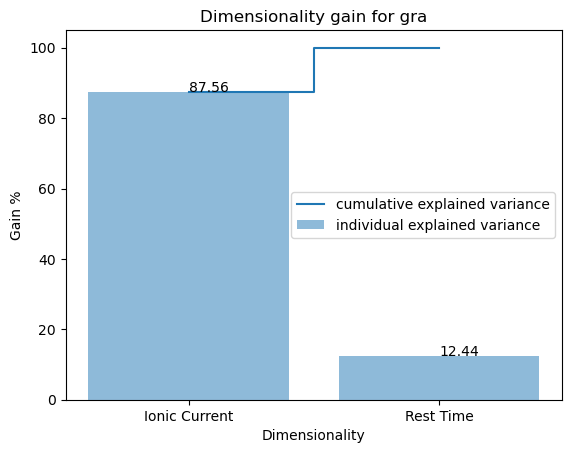

   Eigenvalues  Feature Number
0     0.788633               1
1     0.094388               3
2     0.047423               2


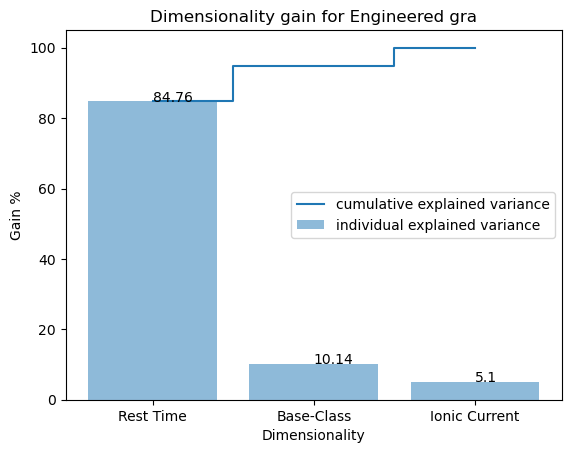

mos
   Eigenvalues  Feature Number
0     0.432829               2
1     0.027813               1


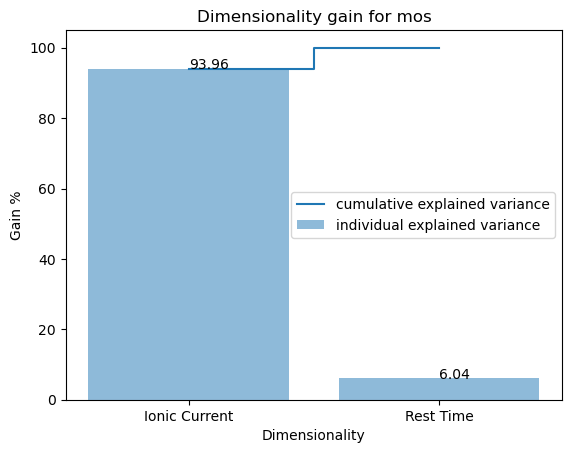

   Eigenvalues  Feature Number
0     0.788633               1
1     0.094388               3
2     0.047423               2


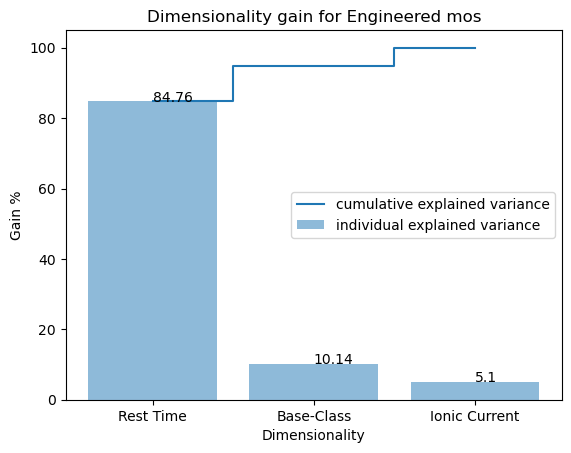

phos
   Eigenvalues  Feature Number
0     0.265445               2
1     0.036253               1


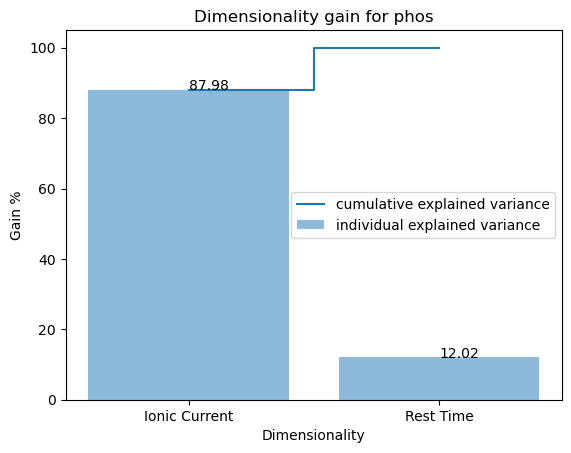

   Eigenvalues  Feature Number
0     0.788633               1
1     0.094388               3
2     0.047423               2


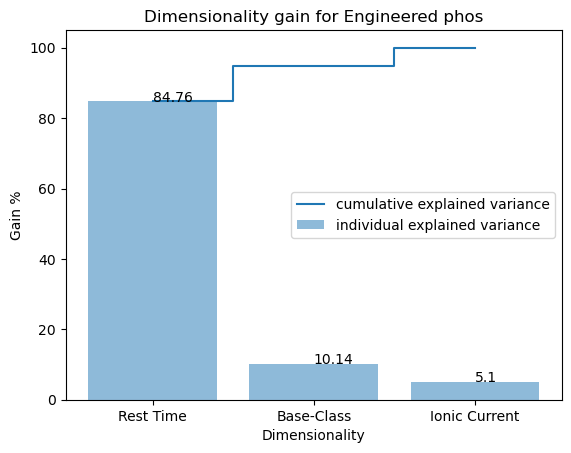

mxene
   Eigenvalues  Feature Number
0      0.34769               2
1      0.05137               1


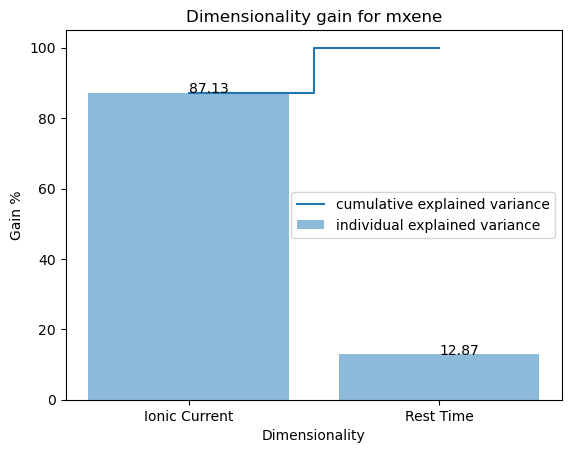

   Eigenvalues  Feature Number
0     0.788633               1
1     0.094388               3
2     0.047423               2


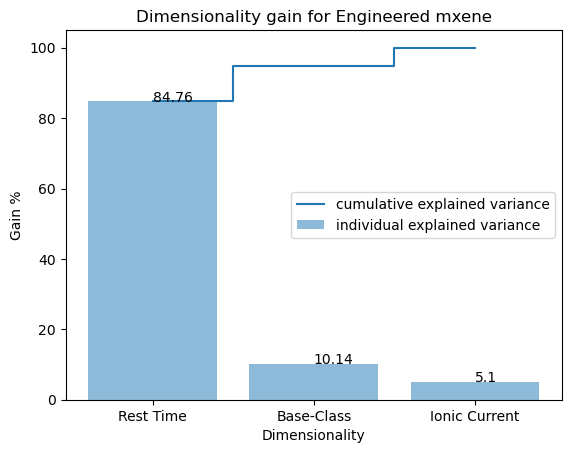

In [17]:
# Let's start for all pores
my_vars = vars()
for ind, pore in enumerate(pores):
    print(pore)
    my_vars[f'X{pore}'],my_vars[f'y{pore}'],my_vars[f'dna_{pore}'],my_vars[f'Xeng_{pore}'] = nucleotide_pore_data(name=pore)
    my_vars[f'var_weights_{pore}'],my_vars[f'sorted_eig_vecs{pore}'] =  eval(my_vars[f'X{pore}'], pore)
    my_vars[f'var_weights_{pore}_e'],my_vars[f'sorted_eig_vecs{pore}_e'] =  eval(my_vars[f'Xeng_{pores[0]}'], pore, 1)

# Feature Mapping

In [76]:
trans = PolynomialFeatures(degree=1)
data = trans.fit_transform(Xmxene)
data_eng = trans.fit_transform(Xeng_mxene)

   Eigenvalues  Feature Number
0     1.320022               1
1     0.065282               3
2     0.013757               2


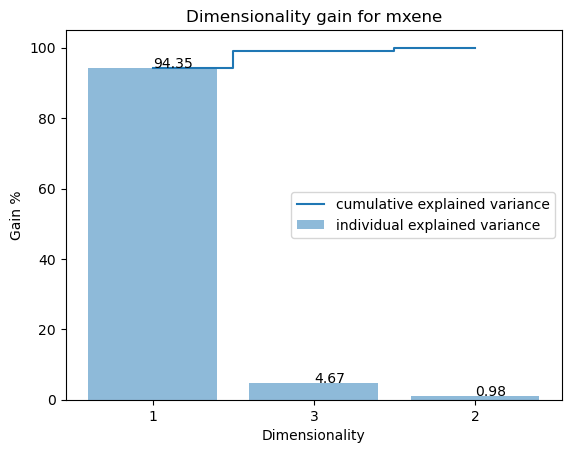

(array([[0.9435058 , 0.99016688, 1.        ]]),
 [array([-0.86753281, -0.20401671, -0.45361218]),
  array([-0.24651147, -0.61574594,  0.74839096]),
  array([-0.43199412,  0.76107432,  0.48388735])])

In [77]:
eval(data, 'mxene',eng = 0, mode='expanded')

   Eigenvalues  Feature Number
0     1.680976               1
1     0.193428               2
2     0.060882               4
3     0.013624               3


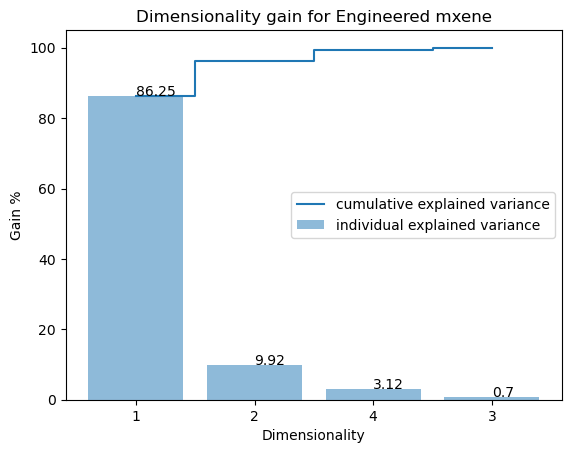

(array([[0.86252117, 0.96177043, 0.99300956, 1.        ]]),
 [array([0.75393033, 0.17137319, 0.40031017, 0.49190655]),
  array([ 0.45430496,  0.22900738,  0.0974374 , -0.85537628]),
  array([-0.17963381, -0.57530087,  0.78168837, -0.16038672]),
  array([-0.43923542,  0.76630005,  0.46821044,  0.02520848])])

In [78]:
eval(data_eng, 'mxene',eng = 1, mode='expanded')

# KMeans

In [20]:
# k-means
from sklearn.cluster import KMeans
from matplotlib.cm import ScalarMappable

In [19]:
def decision_boundary_grid(X, extra_margin = 0.5, sampling_rate= 1000):
    

    x_min = np.min(X[:,0])
    y_min = np.min(X[:,1])
    x_max = np.max(X[:,0])
    y_max = np.max(X[:,1])
    sampling_intervalx = (x_max-x_min)/sampling_rate
    sampling_intervaly = (y_max-y_min)/sampling_rate
    x_axis = np.arange(x_min-(np.abs(x_min)*extra_margin), x_max+(np.abs(x_min)*extra_margin), sampling_intervalx)
    y_axis = np.arange(y_min-(np.abs(y_min)*extra_margin), y_max+(np.abs(y_min)*extra_margin), sampling_intervaly)
    x_mesh, y_mesh = np.meshgrid(x_axis, y_axis)
    x_mesh_flatten = x_mesh.flatten()
    y_mesh_flatten = y_mesh.flatten()
    x_mesh_flatten_reshape = x_mesh_flatten.reshape((x_mesh_flatten.shape[0],1))
    y_mesh_flatten_reshape = y_mesh_flatten.reshape((y_mesh_flatten.shape[0],1))
    X_grid = np.hstack((x_mesh_flatten_reshape,y_mesh_flatten_reshape))
    
    return x_mesh, y_mesh, X_grid


In [112]:
def kmeans_decision_boundary(X_grid, x_mesh,y_mesh, func):
    labels_grid = func.predict(X_grid)
    labels_mesh = labels_grid.reshape(x_mesh.shape)
    ax= plt.contourf(x_mesh, y_mesh, labels_mesh, cmap="Set3", alpha=0.8, shading="gouraud", zorder=0)
    # plt.colorbar(ScalarMappable(norm=ax.norm, cmap=ax.cmap),ticks=np.linspace(0,1,2))
    

In [115]:
def kmeans_training(X, y, mode ='regular', name='mxene'):
    (X_train, _, y_train, _) = train_test_split(X, y, test_size =  0.3, random_state=300)
    kmeans = KMeans(n_clusters=4,init='k-means++', max_iter=3000)
    kmeans_ypred= kmeans.fit_predict(X_train)
    x_mesh, y_mesh, X_grid = decision_boundary_grid(X_train, sampling_rate=1000)
    
    if mode=='binary':
        labl_dict={0: 'Purine', 1: 'Pyrimidine'}
    else:
        labl_dict= {0: 'Adenine', 1: 'Cytosine', 2: 'Guanine', 3:'Thymine'}
    
    
    centroids = kmeans.cluster_centers_
    for i in np.unique(y):
        rgb=np.random.rand(3,)
        plt.scatter(X_train[:, 0][(y_train==i).ravel()], X_train[:, 1][(y_train==i).ravel()], color=rgb,label=labl_dict[i])
        
        
    plt.title(f'Kmeans Clustering for {name}')
    plt.legend()
        
    
    
    plt.scatter(centroids[:, 0],centroids[:, 1],marker="*",color="r",s=150)
    kmeans_decision_boundary(X_grid, x_mesh,y_mesh, kmeans)
    plt.show()
    

In [83]:
len(data[:,1])

331

In [86]:
xsel= np.concatenate([data[:,0].reshape(-1,1),data[:,2].reshape(-1,1)], axis=1)

In [88]:
(X_train, X_test, y_train, y_test) = train_test_split(xsel, ymxene, test_size =  0.3, random_state=300)
kmeans = KMeans(n_clusters=4,init='k-means++', max_iter=3000)

In [92]:
kmeans_ypred= kmeans.fit_predict(X_train)
# x_mesh, y_mesh, X_grid = decision_boundary_grid(X_train)
kmeans_ypred_2= kmeans.fit_predict(X_test)

In [94]:
kmeans_score_train = accuracy_score(y_train, kmeans_ypred)
kmeans_score_test = accuracy_score(y_test, kmeans_ypred_2)

In [106]:
kmeans.cluster_centers_

array([[1.        , 0.75622633],
       [1.        , 0.15696581],
       [1.        , 0.35625729],
       [1.        , 0.556193  ]])

In [ ]:
A_score_lF = accuracy_score(y_test[y_test==0], lRanFor_res_pred.reshape(-1,1)[y_test==0])

In [35]:
labl_dict= {0: 'Adenine', 1: 'Cytosine', 2: 'Guanine', 3:'Thymine'}


In [46]:
len((y_train==0).ravel())

231

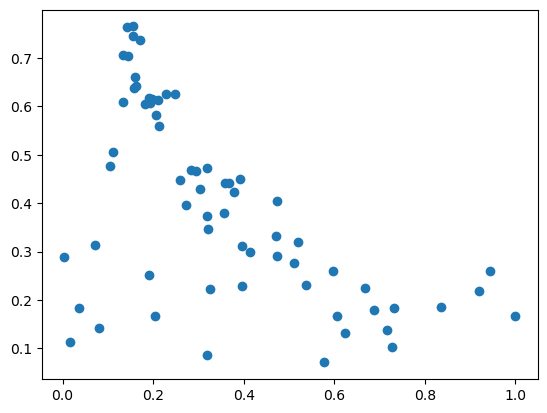

In [47]:
plt.scatter(X_train[:, 0][(y_train==0).ravel()], X_train[:, 1][(y_train==0).ravel()])

Text(0.5, 1.0, 'Kmeans Clustering for mxene')

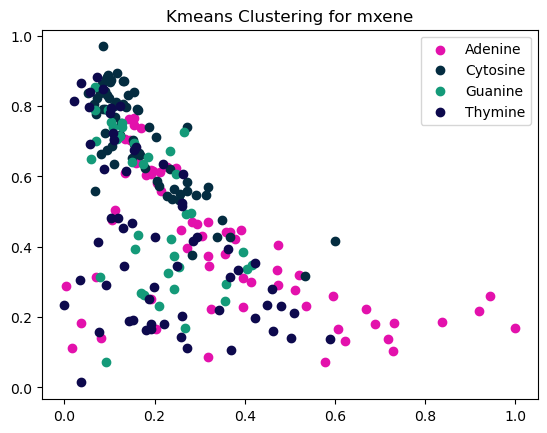

In [49]:
for i in np.unique(ymxene):
    rgb=np.random.rand(3,)
    plt.scatter(X_train[:, 0][(y_train==i).ravel()], X_train[:, 1][(y_train==i).ravel()], color=rgb,label=labl_dict[i])
        
plt.legend()
plt.title(f'Kmeans Clustering for mxene')

gra


/tmp/ipykernel_47442/208909894.py:4: UserWarning: The following kwargs were not used by contour: 'shading'
  ax= plt.contourf(x_mesh, y_mesh, labels_mesh, cmap="Set3", alpha=0.8, shading="gouraud", zorder=0)


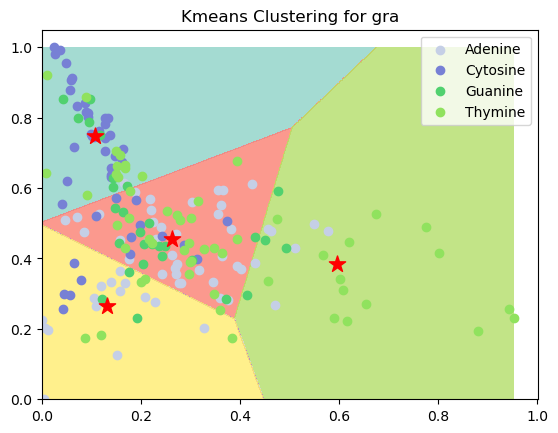

mos


/tmp/ipykernel_47442/208909894.py:4: UserWarning: The following kwargs were not used by contour: 'shading'
  ax= plt.contourf(x_mesh, y_mesh, labels_mesh, cmap="Set3", alpha=0.8, shading="gouraud", zorder=0)


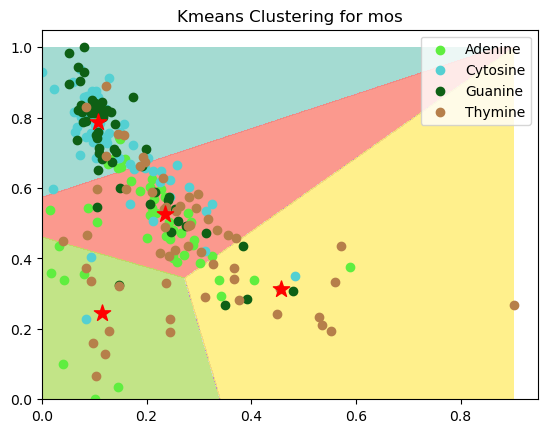

phos


/tmp/ipykernel_47442/208909894.py:4: UserWarning: The following kwargs were not used by contour: 'shading'
  ax= plt.contourf(x_mesh, y_mesh, labels_mesh, cmap="Set3", alpha=0.8, shading="gouraud", zorder=0)


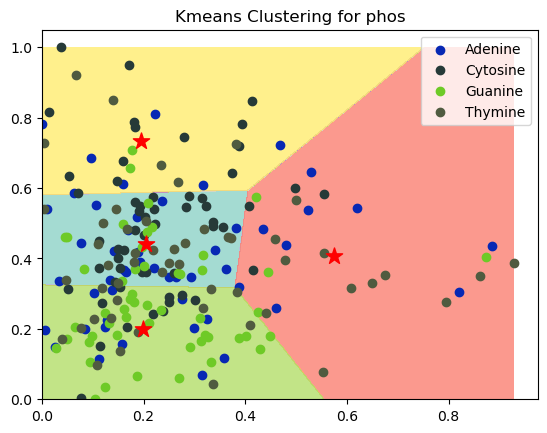

mxene


/tmp/ipykernel_47442/208909894.py:4: UserWarning: The following kwargs were not used by contour: 'shading'
  ax= plt.contourf(x_mesh, y_mesh, labels_mesh, cmap="Set3", alpha=0.8, shading="gouraud", zorder=0)


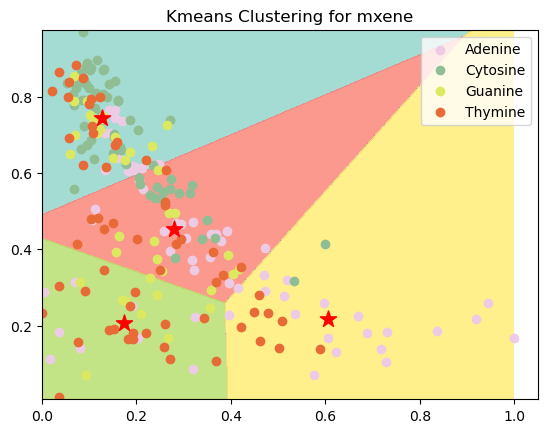

In [116]:
for ind, pore in enumerate(pores):
    print(pore)
    kmeans_training(my_vars[f'X{pore}'], my_vars[f'y{pore}'], name=pore)
    # eval(my_vars[f'X{pore}'], pore)
    # my_vars[f'var_weights_{pore}_e'],my_vars[f'sorted_eig_vecs{pore}_e'] =  eval(my_vars[f'Xeng_{pores[0]}'], pore, 1)